In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import math
import numpy as np
from scipy.signal import detrend
import pywt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))


In [2]:
from signal_modules.base.signal_module import SignalModule
from regression.Kalman_filter import KalmanFilter

In [3]:
noise = 1e-3
kalman = KalmanFilter(process_noise=noise, obs_noise_scale=3 * noise)

In [4]:
signal_module = SignalModule(oracle=kalman, smoothing_window=1)

In [ ]:
initial_time = pd.to_datetime('2023-06-01T12:00:00+00:00')
final_time = pd.Timestamp('2024-01-01T12:00:00+00:00')

tickers = ["SPY", "NVDA", "TSLA", "BRK-B"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

In [6]:
signal_module.generate_signals({tk: s[-40:-1] for tk, s in closing_data.items()})

SignalResult(signals=array([0.59218677, 0.99999   ]), raw_predictions=array([468.28610957,  49.32377249]), smoothed_predictions=array([[467.54853792,  49.18561958],
       [468.28610957,  49.32377249]]), volatility_adjustments=array([1.66828989, 0.57926634]), tickers=['SPY', 'NVDA'])

In [7]:
for i in range(40, len(list(closing_data.values())[0])):
    print(signal_module.generate_signals({tk: s[max(0, i-40):i] for tk, s in closing_data.items()}).signals)

[0.45611866 0.99999   ]
[0.15713664 0.99999   ]
[-0.31546289 -0.99999   ]
[-0.52450249 -0.99999   ]
[-0.99999    -0.83802476]
[0.25146884 0.99999   ]
[-0.29908416 -0.99999   ]
[-0.16947056 -0.99999   ]
[-0.13674066 -0.99999   ]
[-0.05968698 -0.99999   ]
[0.11155424 0.99999   ]
[-0.41109355  0.99999   ]
[-0.99999     0.28765086]
[-0.99999    -0.09952277]
[-0.99999    -0.24355916]
[0.02541863 0.99999   ]
[-0.10351461  0.99999   ]
[0.26578582 0.99999   ]
[-0.36491491  0.99999   ]
[ 0.22925849 -0.99999   ]
[0.70905321 0.99999   ]
[0.41754877 0.99999   ]
[0.42733802 0.99999   ]
[0.32656262 0.99999   ]
[ 0.99999    -0.86015399]
[-0.60789618 -0.99999   ]
[-0.2504045 -0.99999  ]
[-0.22114432 -0.99999   ]
[-0.08174436 -0.99999   ]
[ 0.19459787 -0.99999   ]
[-0.12403253 -0.99999   ]
[-0.74401009  0.99999   ]
[0.99999    0.30143056]
[-0.2213348 -0.99999  ]
[-0.20251042 -0.99999   ]
[-0.21136783 -0.99999   ]
[-0.30126667 -0.99999   ]
[-0.47120501 -0.99999   ]
[-0.96472612 -0.99999   ]
[-0.85492956

Analyzing shared timeline across tickers...
Found 146 shared trading days
Date range: 2023-06-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Generating historical signals...


Processing timeline: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s]


                                SPY      NVDA
2023-08-01 00:00:00+00:00  0.456119  0.999990
2023-08-02 00:00:00+00:00  0.157137  0.999990
2023-08-03 00:00:00+00:00 -0.315463 -0.999990
2023-08-04 00:00:00+00:00 -0.524502 -0.999990
2023-08-07 00:00:00+00:00 -0.999990 -0.838025
...                             ...       ...
2023-12-22 00:00:00+00:00  0.999990  0.820978
2023-12-26 00:00:00+00:00  0.999990 -0.211822
2023-12-27 00:00:00+00:00  0.831613  0.999990
2023-12-28 00:00:00+00:00  0.775562  0.999990
2023-12-29 00:00:00+00:00  0.592187  0.999990

[106 rows x 2 columns]
Successfully generated signals for 106 time points
Creating diagnostic visualizations...


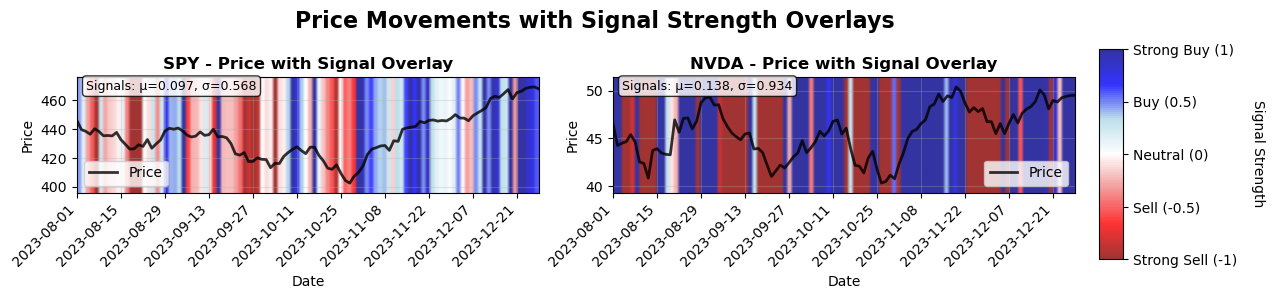


DIAGNOSTIC SUMMARY
Analysis period: 2023-08-01 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Number of signal observations: 106
Smoothing window used: 1 days

Signal Statistics by Ticker:
----------------------------------------
     SPY: μ=+0.097, σ=0.568, range=[-1.000, +1.000]
    NVDA: μ=+0.138, σ=0.934, range=[-1.000, +1.000]

Signal Correlation Matrix:
------------------------------
             SPY    NVDA
     SPY   1.000   0.364
    NVDA   0.364   1.000


In [8]:
signal_module.diagnostics(data=closing_data)